In [2]:
import numpy as np
import os

# стабильный вывод при всех запусках
np.random.seed(42)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# игнорировать предупреждения
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Полиномиальная реrрессия

In [3]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [4]:
# сгенерируем нелинейные данные,основываясь на простом квадратном уравнении (у = ах**2 + Ьх + с.) плюс некоторый шум
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Прямая линия никогда не будет подогнана под такие данные должным образом

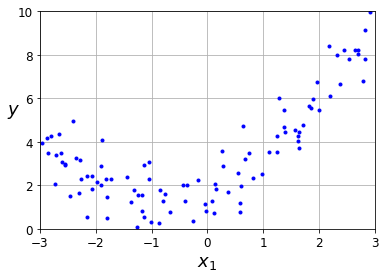

In [5]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show();

Воспользуемся классом PolynomialFeatures из Scikit-Learn, чтобы преобразовать наши обучающие данные, добавив в качестве
новых признаков квадрат (полином 2-й степени) каждого признака (в этом случае есть только один признак)

In [6]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [7]:
X_poly[0]

array([-0.75275929,  0.56664654])

Теперь X_poly содержит первоначальный признак Х плюс его квадрат. Далее вы можете подогнать модель LinearRegression к таким расширенным обучающим данным

In [8]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Модель оценивает функцию как у = 0.56 х2+ 0.93х + 1.78, когда на самом деле исходной функцией была у = 0.5х2+ 1.0х + 2 + гауссов шум.

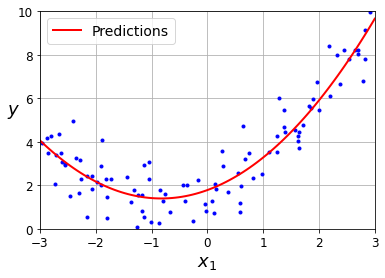

In [9]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

Обратите внимание, что при наличии множества признаков полиномиальная регрессия способна отыскать связи между признаками (то, что простая линейная регрессионная модель делать не в состоянии). Это становится возможным благодаря тому факту, что класс PolynornialFeatures также добавляет все комбинации признаков вплоть до заданной степени. Например, если есть два признака а и Ь, тогда PolynornialFeatures с degree=З добавил бы не только признаки а2, а3, Ь2 и Ь3, но и комбинации аЬ, а2Ь и аЬ2.

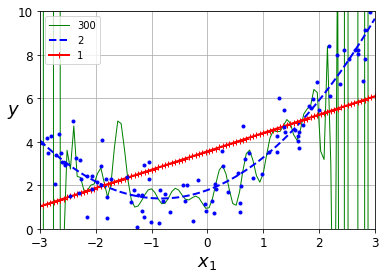

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

# Реrуляризированные линейные модели

Как было показано выше, хороший способ сократить переобучение заключается в том, чтобы регуляризировать модель (т.е. ограничить ее):чем меньше степеней свободы она имеет, тем труднее ее будет переобучить данными. Например, простой метод регуляризации полиномиальной модели предполагает понижение количества полиномиальных степеней.
Для линейной модели регуляризация обычно достигается путем ограничения весов модели. Рассмотрим гребневую регрессию (ridge regression), лассо-регрессию (lasso regression) и эластичную сеть (elastic net), которые реализуют три разных способа ограничения весов.

## Гребневая регрессия (ridge regression)

Гребневая регрессия (также называемая регуляризацией Тихонова) является регуляризированной версией линейной регрессии: к функции издержек добавляется член регуляризации (regularization term). Это заставляет алгоритм обучения не только приспосабливаться к данным, но также удерживать веса модели насколько возможно небольшими.

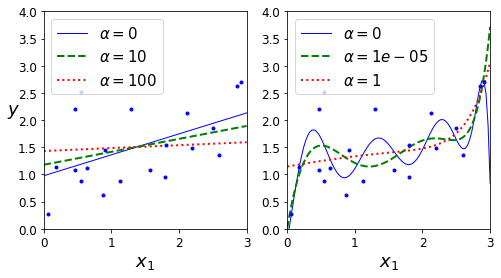

In [11]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

Слева применялись обыкновенные гребневые модели, приводя к линейным прогнозам. Справа данные были сначала расширены с применением PolynomialFeatures (degree=10) , затем масштабированы с использованием StandardScaler и в заключение к результирующим признакам были применены гребневые модели: это полиномиальная регрессия с гребневой регуляризацией. Обратите внимание на то, как увеличение а ведет к более ровным ( т.е. менее предельным, более рациональным) прогнозам.

In [12]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [12]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

## Лассо-реrрессия

Регрессия методом наименьшего абсолютного сокращения и выбора (least absolute shrinkage and selectioti operator (lasso) regression), называемая просто лассо-регрессией, представляет собой еще одну регуляризированную версию линейной регрессии: в точности как гребневая регрессия она добавляет к функции издержек член регуляризации, но вместо одной второй квадрата
нормы l2 весового вектора использует норму l1 весового вектора.

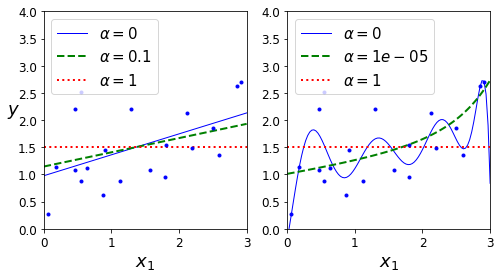

In [13]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-5, 1), tol=1, random_state=42)

plt.show()

Важной характеристикой лассо-регрессии является то, что она стремится полностью исключить веса наименее важных признаков (т.е. устанавливает их в ноль).

In [13]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## Эластичная сеть

Эластичная сеть - это серединная точка между гребневой регрессией и лассо-регрессией. Член регуляризации представляет собой просто смесь членов регуляризации гребневой регрессии и лассо-регрессии, к тому же можно управлять отношением смеси l1_ratio. При l1_ratio = 0 эластичная сеть эквивалентна гребневой регрессии, а при l1_ratio = 1 она эквивалентна лассо-регрессии.

In [15]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])